### Download the code zip file

In [7]:
!wget https://pyimagesearch-code-downloads.s3.us-west-2.amazonaws.com/pytorch-object-detection/pytorch-object-detection.zip
!unzip -qq pytorch-object-detection.zip
%cd pytorch-object-detection

--2023-09-20 09:03:53--  https://pyimagesearch-code-downloads.s3.us-west-2.amazonaws.com/pytorch-object-detection/pytorch-object-detection.zip
Resolving pyimagesearch-code-downloads.s3.us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3.us-west-2.amazonaws.com)... 52.218.200.33, 3.5.87.65, 3.5.78.123, ...
Connecting to pyimagesearch-code-downloads.s3.us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3.us-west-2.amazonaws.com)|52.218.200.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 401785 (392K) [application/zip]
Saving to: ‘pytorch-object-detection.zip’

pytorch-object-dete 100%[===================>] 392.37K   528KB/s    in 0.7s    

2023-09-20 09:03:55 (528 KB/s) - ‘pytorch-object-detection.zip’ saved [401785/401785]

/content/pytorch-object-detection/pytorch-object-detection


### Import Packages

In [8]:
from torchvision.models import detection
import matplotlib.pyplot as plt
import numpy as np
import argparse
import pickle
import torch
import cv2

### Function to display images in Jupyter Notebooks and Google Colab

In [9]:
def plt_imshow(title, image):
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

### Implementing our PyTorch object detection script


In [10]:
# # construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-i", "--image", type=str, required=True,
# 	help="path to the input image")
# ap.add_argument("-m", "--model", type=str, default="frcnn-resnet",
# 	choices=["frcnn-resnet", "frcnn-mobilenet", "retinanet"],
# 	help="name of the object detection model")
# ap.add_argument("-l", "--labels", type=str, default="coco_classes.pickle",
# 	help="path to file containing list of categories in COCO dataset")
# ap.add_argument("-c", "--confidence", type=float, default=0.5,
# 	help="minimum probability to filter weak detections")
# args = vars(ap.parse_args())

# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
    "image": "/content/pytorch-object-detection/images/example 8.jpg",
    "model": "retinanet",
    "labels": "coco_classes.pickle",
    "confidence": 0.5
}

In [11]:
# set the device we will be using to run the model
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load the list of categories in the COCO dataset and then generate a
# set of bounding box colors for each class
CLASSES = pickle.loads(open(args["labels"], "rb").read())
COLORS = np.random.uniform(0, 255, size=(len(CLASSES), 3))

In [12]:
# initialize a dictionary containing model name and it's corresponding
# torchvision function call
MODELS = {
	"frcnn-resnet": detection.fasterrcnn_resnet50_fpn,
	"frcnn-mobilenet": detection.fasterrcnn_mobilenet_v3_large_320_fpn,
	"retinanet": detection.retinanet_resnet50_fpn
}

# load the model and set it to evaluation mode
model = MODELS[args["model"]](pretrained=True, progress=True,
	num_classes=len(CLASSES), pretrained_backbone=True).to(DEVICE)
model.eval()
print("")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RetinaNet_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=RetinaNet_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight 

In [13]:
# load the image from disk
image = cv2.imread(args["image"])
orig = image.copy()

# convert the image from BGR to RGB channel ordering and change the
# image from channels last to channels first ordering
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = image.transpose((2, 0, 1))

# add the batch dimension, scale the raw pixel intensities to the
# range [0, 1], and convert the image to a floating point tensor
image = np.expand_dims(image, axis=0)
image = image / 255.0
image = torch.FloatTensor(image)

# send the input to the device and pass the it through the network to
# get the detections and predictions
image = image.to(DEVICE)
detections = model(image)[0]

[INFO] vase: 89.21%
[INFO] couch: 83.68%
[INFO] bowl: 76.84%
[INFO] potted plant: 73.39%
[INFO] tv: 60.58%
[INFO] bird: 59.79%
[INFO] chair: 52.73%
[INFO] chair: 52.67%
[INFO] orange: 52.53%
[INFO] vase: 51.97%


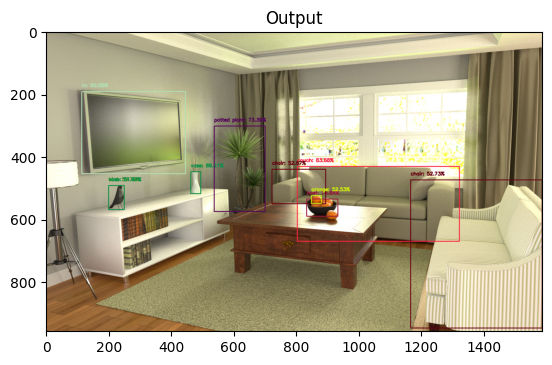

In [14]:
# loop over the detections
for i in range(0, len(detections["boxes"])):
	# extract the confidence (i.e., probability) associated with the
	# prediction
	confidence = detections["scores"][i]

	# filter out weak detections by ensuring the confidence is
	# greater than the minimum confidence
	if confidence > args["confidence"]:
		# extract the index of the class label from the detections,
		# then compute the (x, y)-coordinates of the bounding box
		# for the object
		idx = int(detections["labels"][i])
		box = detections["boxes"][i].detach().cpu().numpy()
		(startX, startY, endX, endY) = box.astype("int")

		# display the prediction to our terminal
		label = "{}: {:.2f}%".format(CLASSES[idx], confidence * 100)
		print("[INFO] {}".format(label))

		# draw the bounding box and label on the image
		cv2.rectangle(orig, (startX, startY), (endX, endY),
			COLORS[idx], 2)
		y = startY - 15 if startY - 15 > 15 else startY + 15
		cv2.putText(orig, label, (startX, y),
			cv2.FONT_HERSHEY_SIMPLEX, 0.5, COLORS[idx], 2)

# show the output image
plt_imshow("Output", orig)